In [1]:
%load_ext autoreload
%autoreload 2

import scipy

scipy.signal.blackmanharris = scipy.signal.windows.blackmanharris  # if there is an error


# append parent directory to path (../notebooks -> ..)
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm
from einops import rearrange

from ldns.data.latent_attractor import get_attractor_dataloaders, LatentDataset
from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *  # all plotting functions
from ldns.networks import Denoiser
from ldns.utils.plotting_utils import evaluate_autoencoder
from diffusers.training_utils import EMAModel
from diffusers.schedulers import DDPMScheduler

import lovely_tensors as lt

lt.monkey_patch()  # pretty printing of tensors

matplotlib.rc_file("matplotlibrc")


In [6]:
cfg_ae = OmegaConf.load("conf/autoencoder-Lorenz_z=8.yaml")

# this is for the diffusion model
cfg = OmegaConf.load("conf/diffusion_Lorenz.yaml")

cfg.dataset = cfg_ae.dataset

print(OmegaConf.to_yaml(cfg))

denoiser_model:
  C_in: 8
  C: 64
  num_blocks: 4
  bidirectional: true
  num_train_timesteps: 1000
training:
  lr: 0.001
  num_epochs: 1000
  num_warmup_epochs: 50
  batch_size: 512
  random_seed: 42
  precision: 'no'
exp_name: diffusion_Lorenz
dataset:
  system_name: Lorenz
  signal_length: 256
  n_ic: 5000
  mean_rate: 0.3
  split_frac_train: 0.7
  split_frac_val: 0.1
  random_seed: 42
  softplus_beta: 2.0



In [7]:
ae_model = AutoEncoder(
    C_in=cfg_ae.model.C_in,
    C=cfg_ae.model.C,
    C_latent=cfg_ae.model.C_latent,
    L=cfg_ae.dataset.signal_length,
    num_blocks=cfg_ae.model.num_blocks,
    num_blocks_decoder=cfg_ae.model.num_blocks_decoder,
    num_lin_per_mlp=cfg_ae.model.get("num_lin_per_mlp", 2),  # default 2
)

ae_model = CountWrapper(ae_model)

# load model we trained
ae_model.load_state_dict(torch.load(f"exp/stored_models/{cfg_ae.exp_name}/model.pt", map_location="cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ae_model = ae_model.to(device)

train_dataloader, val_dataloader, test_dataloader = get_attractor_dataloaders(
    system_name=cfg.dataset.system_name,
    n_neurons=cfg_ae.model.C_in,
    sequence_length=cfg_ae.dataset.signal_length,
    n_ic=cfg_ae.dataset.n_ic,
    mean_spike_count=cfg_ae.dataset.mean_rate * cfg_ae.dataset.signal_length,
    train_frac=cfg_ae.dataset.split_frac_train,
    valid_frac=cfg_ae.dataset.split_frac_val,  # test is 1 - train - valid
    random_seed=cfg_ae.training.random_seed,
    batch_size=cfg_ae.training.batch_size,
    softplus_beta=cfg_ae.dataset.get("softplus_beta", 2.0),
)


/tmp/ipykernel_210248/2352107656.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load(f"exp/stored_models/{cfg_ae.exp_name}/model.pt", ma

Simulating Lorenz:   0%|          | 0/5000 [00:00<?, ?it/s]

/mnt/lustre/work/macke/jkapoor83/repos/LDNS/ldns/data/latent_attractor.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(results, dtype=torch.float32)


In [8]:
# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x


accelerator = accelerator = accelerate.Accelerator(mixed_precision=cfg.training.precision)

# prepare the ae model and dataset
(
    ae_model,
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    ae_model,
    train_dataloader,
    val_dataloader,
    test_dataloader,
)


# create the latent dataset
latent_dataset_train = LatentDataset(train_dataloader, ae_model)
latent_dataset_val = LatentDataset(
    val_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
)
latent_dataset_test = LatentDataset(
    test_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Creating latent dataset:   0%|          | 0/7 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# prepare longer dataset

train_dataloader_longer, val_dataloader_longer, test_dataloader_longer = get_attractor_dataloaders(
    system_name=cfg_ae.dataset.system_name,
    n_neurons=cfg_ae.model.C_in,
    sequence_length=cfg_ae.dataset.signal_length * 16,
    n_ic=cfg_ae.dataset.n_ic,
    mean_spike_count=cfg_ae.dataset.mean_rate * cfg_ae.dataset.signal_length * 16,
    train_frac=cfg_ae.dataset.split_frac_train,
    valid_frac=cfg_ae.dataset.split_frac_val,  # test is 1 - train - valid
    random_seed=cfg_ae.training.random_seed,
    batch_size=cfg_ae.training.batch_size,
    softplus_beta=cfg_ae.dataset.get("softplus_beta", 2.0),
)

train_dataloader_longer, val_dataloader_longer, test_dataloader_longer = accelerator.prepare(
    train_dataloader_longer, val_dataloader_longer, test_dataloader_longer
)


Simulating Lorenz:   0%|          | 0/5000 [00:00<?, ?it/s]

In [15]:
# load diffusion model

denoiser = Denoiser(
    C_in=cfg.denoiser_model.C_in,
    C=cfg.denoiser_model.C,
    L=cfg.dataset.signal_length,
    num_blocks=cfg.denoiser_model.num_blocks,
    bidirectional=cfg.denoiser_model.get("bidirectional", True),
)

scheduler = DDPMScheduler(
    num_train_timesteps=cfg.denoiser_model.num_train_timesteps,
    clip_sample=False,
    beta_schedule="linear",
)

denoiser.load_state_dict(torch.load(f"exp/stored_models/{cfg.exp_name}/model.pt", map_location="cpu"))

(denoiser, latent_dataset_train, latent_dataset_val, latent_dataset_test) = accelerator.prepare(
    denoiser, latent_dataset_train, latent_dataset_val, latent_dataset_test
)
ema_denoiser = EMAModel(denoiser)  # eval and no grad

/tmp/ipykernel_210248/3599729440.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiser.load_state_dict(torch.load(f"exp/stored_models/{cfg.exp_name}/model.pt", map_l

(-2.0, 128.0)

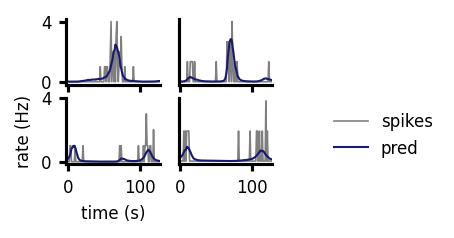

In [16]:
# plot comparison of spikes and predicted rates for 4 example channels

idx = 0

# get single batch of test data
ae_model.eval()
for batch in test_dataloader:
    signal = batch["signal"]
    with torch.no_grad():
        output_rates = ae_model(signal)[0].cpu()
    signal = signal.cpu()
    break

# create 2x2 subplot
fig, ax = plt.subplots(2, 2, figsize=cm2inch(4.5, 3.2), sharex=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2)

# plot 4 example channels
channels = [0, 32, 64, 127]
ax = ax.flatten()
for i, channel in enumerate(channels):
    ax2 = ax[i]
    ax2.plot(signal[idx, channel].numpy(), label="spikes", color="black", lw=0.8, alpha=0.5)
    ax[i].plot(output_rates[idx, channel].numpy(), label="pred", color="midnightblue", lw=1)
    ax2.set_yticks([])

ax[0].set_yticks([0, 4])
ax[2].set_yticks([0, 4])
ax[-1].legend(loc="upper left", bbox_to_anchor=(1.5, 1.5))
ax2.legend(loc="upper left", bbox_to_anchor=(1.5, 1))
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("rate (Hz)")
ax[0].set_xlim(-2, 128)

In [18]:
def sample(ema_denoiser, scheduler, cfg, batch_size=1, generator=None, device="cuda", signal_length=None):
    """Sample from a trained diffusion model.

    Args:
        ema_denoiser: ema denoiser model
        scheduler: Noise scheduler for the diffusion process
        cfg: Configuration object containing model parameters
        batch_size: Number of samples to generate
        generator: Random number generator for reproducibility
        device: Device to run sampling on
        signal_length: Length of signal to generate, defaults to cfg.dataset.signal_length

    Returns:
        Tensor of generated samples with shape (batch_size, channels, signal_length)
    """
    # use default signal length if none provided
    if signal_length is None:
        signal_length = cfg.dataset.signal_length

    # generate initial random noise
    z_t = torch.randn((batch_size, cfg.denoiser_model.C_in, signal_length)).to(device)

    # get averaged model and set to eval mode
    ema_denoiser_avg = ema_denoiser.averaged_model
    ema_denoiser_avg.eval()

    # set number of denoising steps
    scheduler.set_timesteps(cfg.denoiser_model.num_train_timesteps)

    # iteratively denoise the samples
    for t in tqdm(scheduler.timesteps, desc="Sampling DDPM"):
        with torch.no_grad():
            # predict noise at current timestep
            model_output = ema_denoiser_avg(z_t, torch.tensor([t] * batch_size).to(device).long())
        # update sample using scheduler
        z_t = scheduler.step(model_output, t, z_t, generator=generator, return_dict=False)[0]

    return z_t


# set parameters for sampling
sample_cutoff = int(10e5)  # maximum number of samples to use

ae_model.eval()

# initialize lists to store results
ae_rates = []
ae_latents = []
diffusion_rates = []
diffusion_latents = []
gt_spikes = []

true_data = False

if not true_data:
    gt_rates = []
    gt_latents = []

# evaluate autoencoder on training data
count = 0
for batch in train_dataloader:
    signal = batch["signal"]
    with torch.no_grad():
        output_rates, latent = ae_model(signal)
    ae_rates.append(output_rates.cpu())
    ae_latents.append(latent.cpu())
    gt_spikes.append(signal.cpu())
    if not true_data:
        gt_rates.append(batch["rates"].cpu())
        gt_latents.append(batch["latents"].cpu())
    count += 1

# concatenate results along batch dimension
ae_rates = torch.cat(ae_rates, dim=0)
ae_latents = torch.cat(ae_latents, dim=0)
gt_spikes = torch.cat(gt_spikes, dim=0)
if not true_data:
    gt_rates = torch.cat(gt_rates, dim=0)
    gt_latents = torch.cat(gt_latents, dim=0)

# sample from diffusion model
sampled_latents = sample(
    ema_denoiser=ema_denoiser,
    scheduler=scheduler,
    cfg=cfg,
    batch_size=ae_rates.shape[0],
    device="cuda",
    signal_length=cfg.dataset.signal_length,
)

# project latents back to non-standardized space
sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
    sampled_latents.device
) + latent_dataset_train.latent_means.to(sampled_latents.device)

# decode latents to rates
with torch.no_grad():
    sampled_rates = ae_model.decode(sampled_latents).cpu()

diffusion_rates.append(sampled_rates)
diffusion_latents.append(sampled_latents.cpu())

# concatenate diffusion results
diffusion_rates = torch.cat(diffusion_rates, dim=0)
diffusion_latents = torch.cat(diffusion_latents, dim=0)

# collect all vectors
vecs = [ae_rates, ae_latents, diffusion_rates, diffusion_latents, gt_spikes]

vecs.append(gt_rates)
vecs.append(gt_latents)

# convert to numpy and rearrange dimensions
vecs = [vec.cpu().numpy() for vec in vecs]
vecs = [vec[:sample_cutoff] for vec in vecs]
vecs = [rearrange(vec, "b n t -> b t n") for vec in vecs]

# unpack results
ae_rates, ae_latents, diffusion_rates, diffusion_latents, gt_spikes, gt_rates, gt_latents = vecs


Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

In [44]:
# define colors and labels for plotting
color_dict = {
    "ae": "midnightblue",
    "ael": "royalblue",
    "diff": "darkred",
    "diffl": "orangered",
    "gt": "darkgrey",
    "gtl": "#808080",
}

lab_dict = {
    "ae": "ae",
    "ael": "latents ae",
    "diff": "diffusion",
    "diffl": "latents diffusion",
    "gt": "gt",
    "gtl": "latents gt",
}


In [20]:
ae_rates.shape, ae_latents.shape, diffusion_rates.shape, diffusion_latents.shape, gt_spikes.shape

((3500, 256, 128),
 (3500, 256, 8),
 (3500, 256, 128),
 (3500, 256, 8),
 (3500, 256, 128))

### Plotting the latent trajectories, and the 16x longer latent trajectory to show length generalization

In [22]:
# plot 16x longer latent trajectory to show length generalization

from ldns.utils.plotting_utils import plot_3d_latent_trajectory_direct

diffusion_latents_longer = sample(
    ema_denoiser=ema_denoiser,
    scheduler=scheduler,
    cfg=cfg,
    batch_size=10,
    device="cuda",
    signal_length=cfg.dataset.signal_length * 16,
)

diffusion_latents_longer = diffusion_latents_longer * latent_dataset_train.latent_stds.to(
    diffusion_latents_longer.device
) + latent_dataset_train.latent_means.to(diffusion_latents_longer.device)
with torch.no_grad():
    sampled_rates_longer = ae_model.decode(diffusion_latents_longer).cpu()


Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

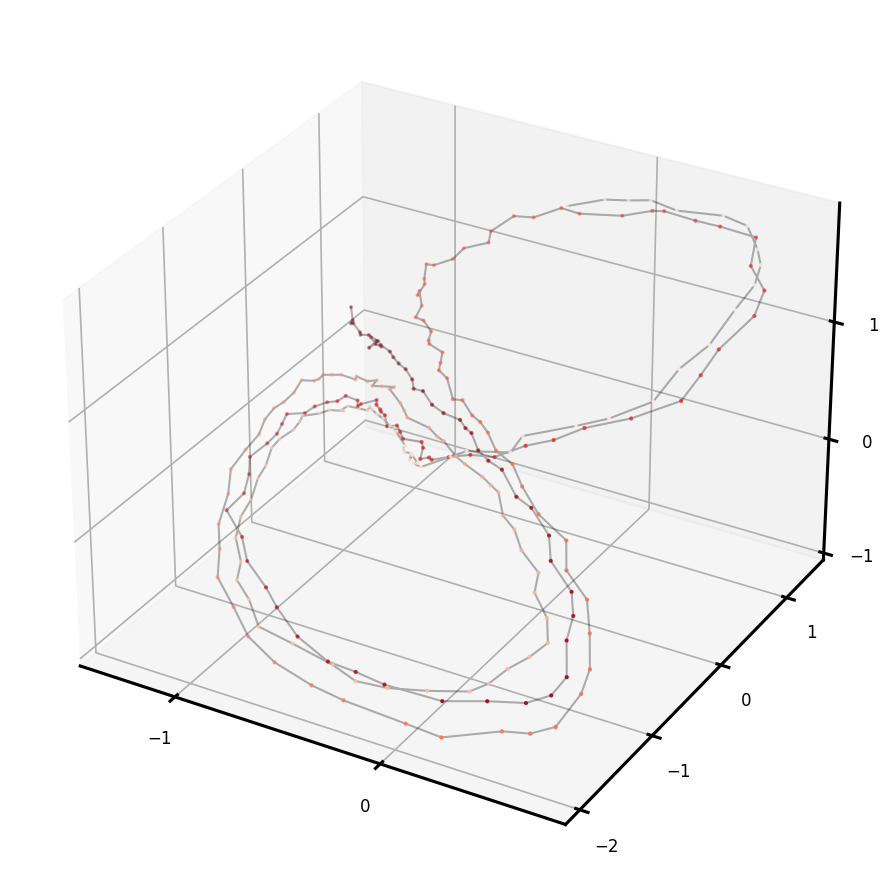

In [32]:
plot_3d_latent_trajectory_direct(
    torch.from_numpy(diffusion_latents).permute(0, 2, 1), cmap="Reds", indices=[1, 5, 3]
)  # change indices to visualize the bistable shape


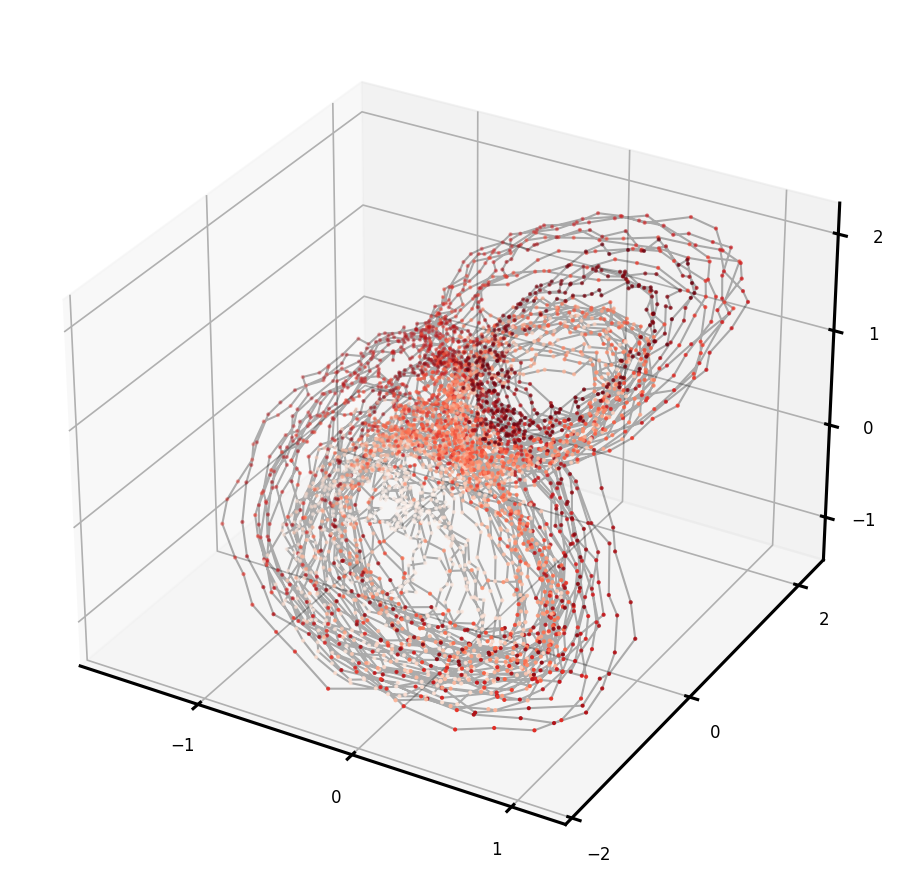

In [33]:
plot_3d_latent_trajectory_direct(
    diffusion_latents_longer, cmap="Reds", indices=[1, 5, 3]
)  # change indices to visualize the bistable shape


### Plotting spectral densitites, spike statistics, and correlation (neuron-neuron, and temporal auto/cross-correlation)

Caution: Ensure fps is correct here.... PSD fps: 1


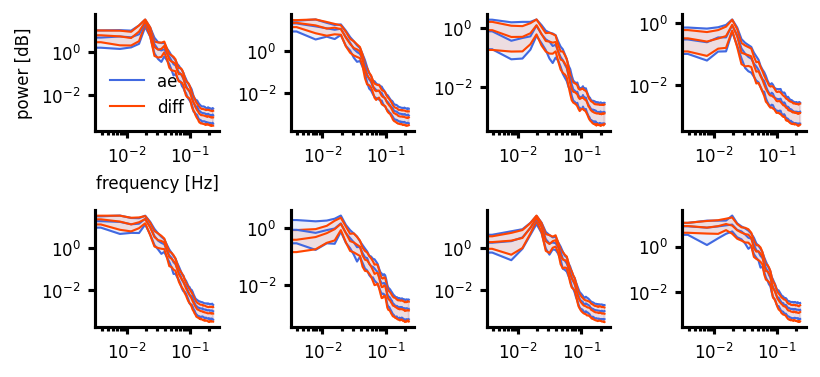

In [35]:
channels = np.random.choice(range(8), 8, replace=False)

plot_n_channel_sd(
    ae_latents,
    diffusion_latents,
    channels=channels,
    fps=1,
    colors=[color_dict["ael"], color_dict["diffl"]],
    labels=["ae", "diff"],
    ystack=2,
    figsize=cm2inch(14, 6.5),
    lw=1,
)

In [36]:
def group_neurons_by_corr(data, num_groups=4):
    """Group neurons by their overall correlation."""
    C_mat = correlation_matrix(gt_spikes, mode="concatenate")
    np.fill_diagonal(C_mat, 0)
    # sum up the square of the correlations
    summed_sq_corr = np.sum(C_mat**2, axis=0)
    sorted_indices = np.argsort(-summed_sq_corr)

    # group size
    group_size = len(sorted_indices) // num_groups
    # split the indices into groups
    groups = [sorted_indices[i * group_size : (i + 1) * group_size] for i in range(num_groups)]
    return groups


grouped_neurons = group_neurons_by_corr(gt_spikes, num_groups=4)

grouped_neurons

[array([105, 102, 109,  99,  98, 100, 119, 110, 113,  77,  97,  88, 124,
         80,  74,  95,  85, 107, 126,  83,  73,  18,  89,  14,   7, 125,
        116,  64,  15,  34,  37,   5]),
 array([ 58,  68,  60,  41,   0,  16,  53,  50,  71,  79,   2, 123,  43,
         67,   6,  57,  48,  35, 127,   3,  59,  13,  42,  33,  32,  23,
         19,  91,  49,   1,  62,  66]),
 array([ 46,  87,  20,  94, 104,  55,  65,   4,  38,  51,  44,  63, 114,
         70, 117, 121,  54,  75,  25,  31,  69,  40,  56,  61, 108,  81,
         76,  22,  12,  39,  30,  52]),
 array([ 17, 120,  82,  84, 122,  47,  29,  45,  78, 111,  86,  24,  72,
        112,  93,  10,  90,  11,  36,  96,   9,  27,  92,  21,  26,  28,
          8, 101, 118, 115, 103, 106])]

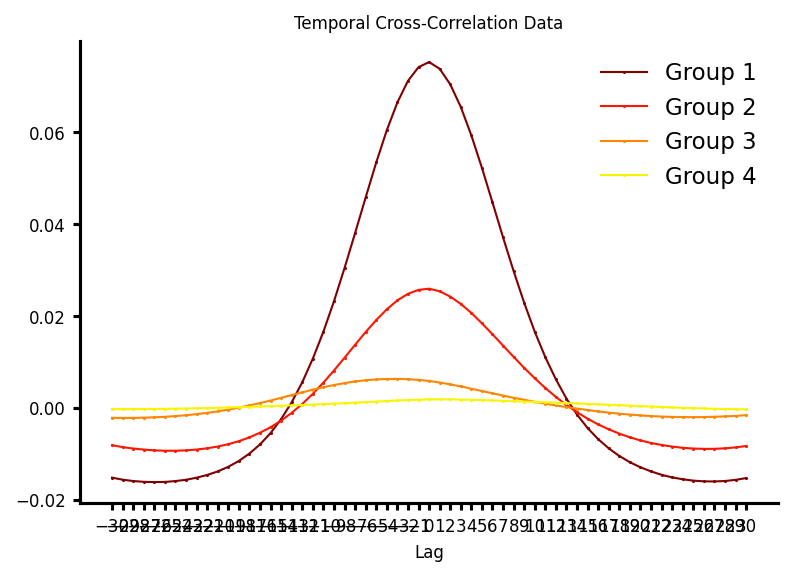

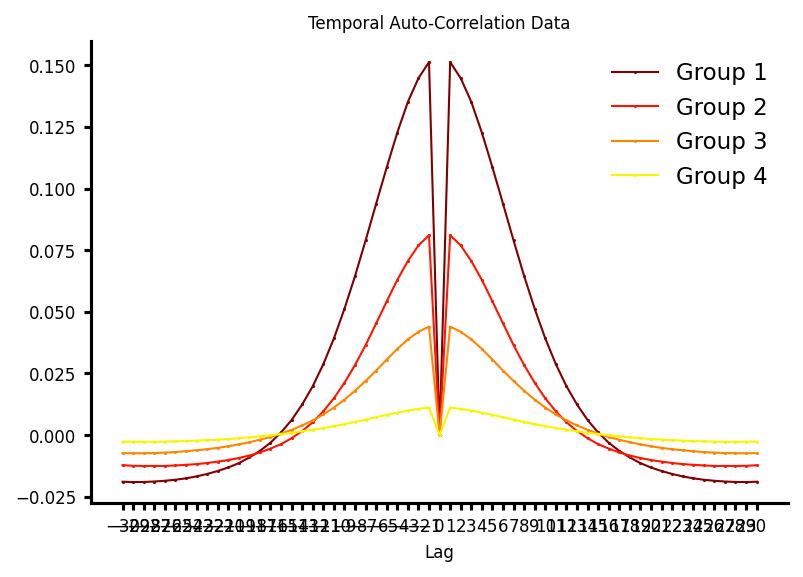

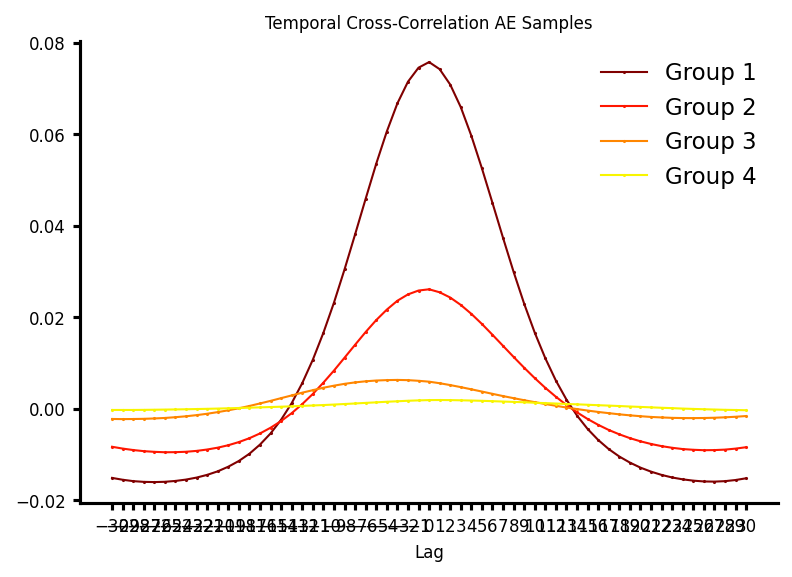

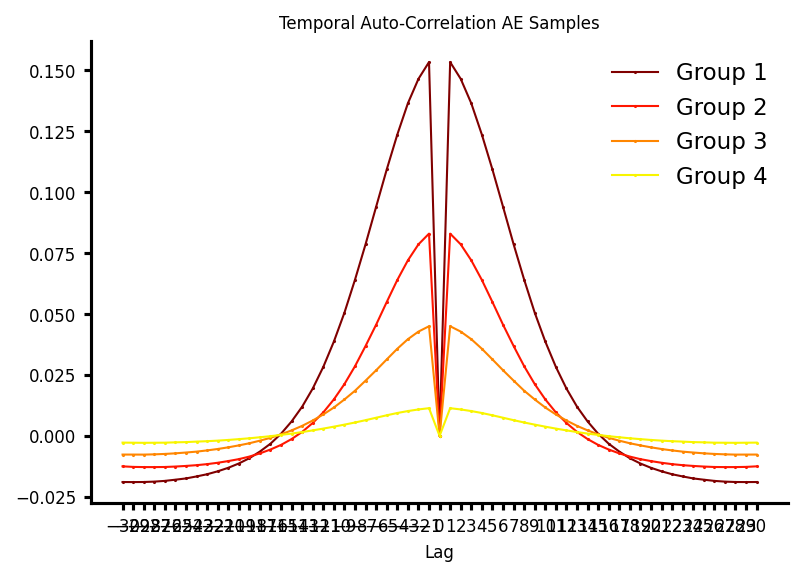

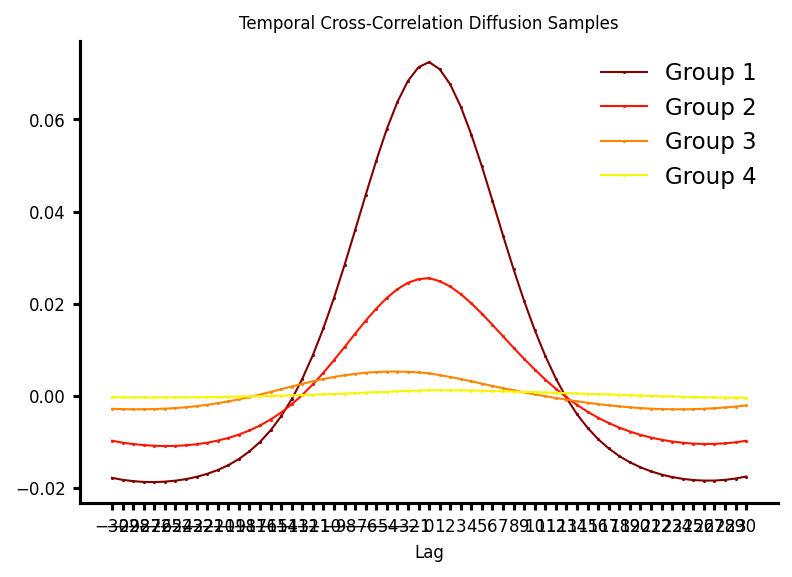

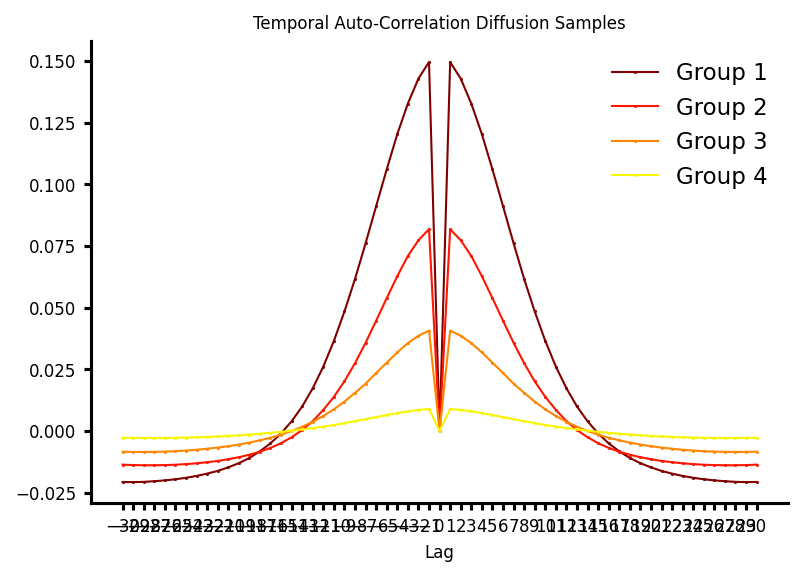

In [37]:
from ldns.utils.eval_utils import group_neurons_temp_corr, get_temp_corr_summary
from ldns.utils.plotting_utils import plot_temp_corr_summary

# generate spike trains from rates using poisson sampling
ae_spikes = np.random.poisson(ae_rates)
diff_spikes = np.random.poisson(diffusion_rates)

# group neurons by correlation for efficient computation
groups = group_neurons_temp_corr(gt_spikes.transpose(1, 0, 2), num_groups=4)

# compute temporal correlations for ground truth data
cross_corr_groups, auto_corr_groups = get_temp_corr_summary(
    gt_spikes.transpose(1, 0, 2), groups, nlags=30, mode="biased", batch_first=False
)
fig_cross, fig_auto = plot_temp_corr_summary(cross_corr_groups, auto_corr_groups, name="Data")

# compute temporal correlations for autoencoder samples
cross_corr_groups_ae, auto_corr_groups_ae = get_temp_corr_summary(
    ae_spikes.transpose(1, 0, 2), groups, nlags=30, mode="biased", batch_first=False
)
fig_cross_ae, fig_auto_ae = plot_temp_corr_summary(cross_corr_groups_ae, auto_corr_groups_ae, name="AE Samples")

# compute temporal correlations for diffusion samples
cross_corr_groups_diff, auto_corr_groups_diff = get_temp_corr_summary(
    diff_spikes.transpose(1, 0, 2), groups, nlags=30, mode="biased", batch_first=False
)
fig_cross_sampled, fig_auto_sampled = plot_temp_corr_summary(
    cross_corr_groups_diff, auto_corr_groups_diff, name="Diffusion Samples"
)


<Axes: title={'center': 'temporal auto-corr ae'}, xlabel='lag', ylabel='auto-corr'>

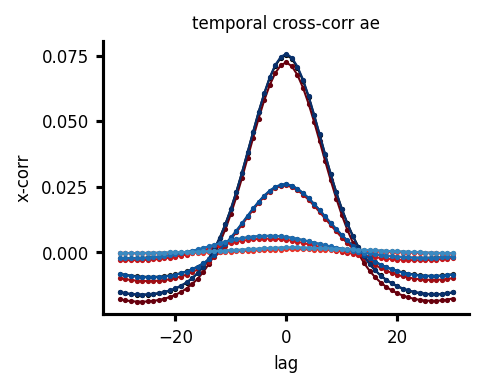

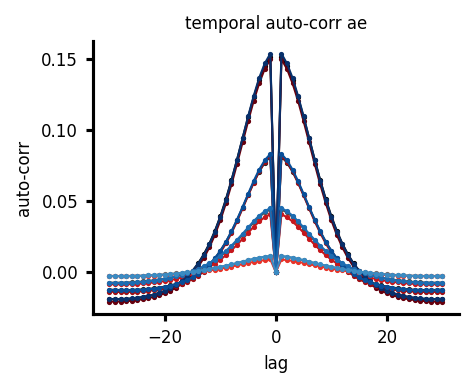

In [38]:
# plot cross-correlation matrices for gt, diffusion and ae
from ldns.utils.plotting_utils import plot_cross_corr_summary

# plot combined cross-correlation matrix
fig, ax = plt.subplots(1, 1, figsize=cm2inch(8, 6))
plot_cross_corr_summary(
    cross_corr_groups,
    name="gt",
    figsize=cm2inch(6, 4),
    cmap="Greys",
    ax_corr=ax,
    labels="gt ",
    ncol=3,
)
plot_cross_corr_summary(
    cross_corr_groups_diff,
    name="diffusion",
    figsize=cm2inch(6, 4),
    cmap="Reds",
    ax_corr=ax,
    labels="diff ",
    ncol=3,
)
plot_cross_corr_summary(
    cross_corr_groups_ae,
    name="ae",
    figsize=cm2inch(6, 4),
    cmap="Blues",
    ax_corr=ax,
    labels="ae ",
    ncol=3,
)

# plot combined auto-correlation matrix
fig, ax = plt.subplots(1, 1, figsize=cm2inch(8, 6))
plot_cross_corr_summary(
    auto_corr_groups,
    name="gt",
    figsize=cm2inch(6, 4),
    cmap="Greys",
    ax_corr=ax,
    labels="gt ",
    ncol=3,
    title="auto-corr",
    ylabel="auto-corr",
)
plot_cross_corr_summary(
    auto_corr_groups_diff,
    name="diffusion",
    figsize=cm2inch(6, 4),
    cmap="Reds",
    ax_corr=ax,
    labels="diff ",
    ncol=3,
    title="auto-corr",
    ylabel="auto-corr",
)
plot_cross_corr_summary(
    auto_corr_groups_ae,
    name="ae",
    figsize=cm2inch(6, 4),
    cmap="Blues",
    ax_corr=ax,
    labels="ae ",
    ncol=3,
    title="auto-corr",
    ylabel="auto-corr",
)

pearsen R mean isi PearsonRResult(statistic=0.9968724439362616, pvalue=9.38045960695675e-141)
pearsen R std isi PearsonRResult(statistic=0.9905038628473941, pvalue=1.884090621148146e-110)
pearsen R corr matrices PearsonRResult(statistic=0.9987952006419742, pvalue=0.0)
pearsen R density gt model PearsonRResult(statistic=0.998813071700593, pvalue=0.0)


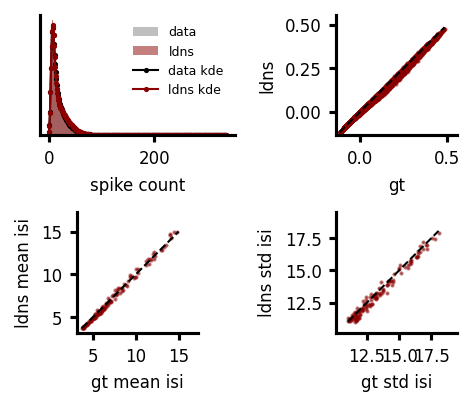

In [39]:
from ldns.utils.eval_utils import correlation_matrix, compute_spike_stats_per_neuron, counts_to_spike_trains
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt


def get_spike_train_and_stats(spikes, fps=1):
    """Get spike train statistics.

    Args:
        spikes: spike count array (batch, time, neurons)
        fps: sampling rate in Hz

    Returns:
        dict: contains mean_isi and std_isi arrays
    """
    spiketrain = counts_to_spike_trains(spikes, fps=fps)
    return compute_spike_stats_per_neuron(
        spiketrain,
        n_samples=spikes.shape[0],
        n_neurons=spikes.shape[2],
        mean_output=False,
    )


# plot population spike histogram for diffusion as well as correlation and isi
diffusion_spikes = np.random.poisson(diffusion_rates)
color_dict = {"ldns": "darkred"}
spikes_dict = {"ldns": diffusion_spikes}

# get max spike count for binning
max_vals = []
for key in spikes_dict.keys():
    max_vals.append(spikes_dict[key].sum(2).max())
max_vals.append(gt_spikes.sum(2).max())
maxval = int(np.max(max_vals))

# plot comparison figures
for i, (key, val) in enumerate(spikes_dict.items()):
    fig, ax = plt.subplots(2, 2, figsize=cm2inch(9, 7))
    ax = ax.flatten()

    # panel 1: population spike count histogram and kde
    kde_model = gaussian_kde(val.sum(2).flatten())
    kde_gt = gaussian_kde(gt_spikes.sum(2).flatten())
    x_eval = np.linspace(0, maxval, maxval + 1)
    density_model = kde_model(x_eval) / kde_model(x_eval).sum()
    density_gt = kde_gt(x_eval) / kde_gt(x_eval).sum()

    bins_psc = np.arange(-0.5, maxval - 0.5, 1)
    ax[0].hist(gt_spikes.sum(2).flatten(), bins=bins_psc, density=True, alpha=0.5, label="data", color="grey")
    ax[0].hist(val.sum(2).flatten(), bins=bins_psc, density=True, alpha=0.5, label=key, color=color_dict[key])
    ax[0].plot(x_eval, density_gt, ".-", label="data kde", color="black")
    ax[0].plot(x_eval, density_model, ".-", label=key + " kde", color=color_dict[key])
    ax[0].legend(fontsize=6)
    ax[0].set_xlabel("spike count")
    ax[0].set_yticks([])

    # panel 2: correlation matrix comparison
    C_model = correlation_matrix(val, mode="concatenate")
    C_gt = correlation_matrix(gt_spikes, mode="concatenate")
    # remove diagonal and upper triangle
    np.fill_diagonal(C_model, 0)
    np.fill_diagonal(C_gt, 0)
    C_model = np.tril(C_model, k=-1)
    C_gt = np.tril(C_gt, k=-1)

    ax[1].plot(C_gt.flatten(), C_model.flatten(), ".", alpha=0.5, color=color_dict[key], ms=2)
    data_limits = [min(C_gt.min(), C_model.min()), max(C_gt.max(), C_model.max())]
    ax[1].plot(data_limits, data_limits, "--", color="black")
    ax[1].set_xlabel("gt")
    ax[1].set_ylabel(key)
    ax[1].set_aspect("equal")
    data_limis_ax = [data_limits[0] - 0.15 * np.abs(data_limits[0]), data_limits[1] + 0.15 * np.abs(data_limits[1])]
    ax[1].set_xlim(data_limis_ax)
    ax[1].set_ylim(data_limis_ax)

    # compute spike train statistics
    spike_stats_gt = get_spike_train_and_stats(gt_spikes)
    spike_stats_model = get_spike_train_and_stats(val)

    # panel 3: mean ISI comparison
    ax[2].plot(
        spike_stats_gt["mean_isi"].flatten(),
        spike_stats_model["mean_isi"].flatten(),
        ".",
        alpha=0.5,
        color=color_dict[key],
        ms=2,
    )
    data_limits = [
        min(spike_stats_gt["mean_isi"].min(), spike_stats_model["mean_isi"].min()),
        max(spike_stats_gt["mean_isi"].max(), spike_stats_model["mean_isi"].max()),
    ]
    ax[2].plot(data_limits, data_limits, "--", color="black")
    ax[2].set_xlabel("gt mean isi")
    ax[2].set_ylabel(key + " mean isi")
    ax[2].set_aspect("equal")
    data_limis_ax = [data_limits[0] - 0.15 * np.abs(data_limits[0]), data_limits[1] + 0.15 * np.abs(data_limits[1])]
    ax[2].set_xlim(data_limis_ax)
    ax[2].set_ylim(data_limis_ax)

    # panel 4: std ISI comparison
    ax[3].plot(
        spike_stats_gt["std_isi"].flatten(),
        spike_stats_model["std_isi"].flatten(),
        ".",
        alpha=0.5,
        color=color_dict[key],
        ms=2,
    )
    data_limits = [
        min(spike_stats_gt["std_isi"].min(), spike_stats_model["std_isi"].min()),
        max(spike_stats_gt["std_isi"].max(), spike_stats_model["std_isi"].max()),
    ]
    ax[3].plot(data_limits, data_limits, "--", color="black")
    ax[3].set_xlabel("gt std isi")
    ax[3].set_ylabel(key + " std isi")
    ax[3].set_aspect("equal")
    data_limis_ax = [data_limits[0] - 0.08 * np.abs(data_limits[0]), data_limits[1] + 0.08 * np.abs(data_limits[1])]
    ax[3].set_xlim(data_limis_ax)
    ax[3].set_ylim(data_limis_ax)

    plt.tight_layout()

    # compute correlations between ground truth and model
    from scipy.stats import pearsonr

    print("pearsen R mean isi", pearsonr(spike_stats_gt["mean_isi"].flatten(), spike_stats_model["mean_isi"].flatten()))
    print("pearsen R std isi", pearsonr(spike_stats_gt["std_isi"].flatten(), spike_stats_model["std_isi"].flatten()))
    print("pearsen R corr matrices", pearsonr(C_gt.flatten(), C_model.flatten()))
    print("pearsen R density gt model", pearsonr(density_gt, density_model))

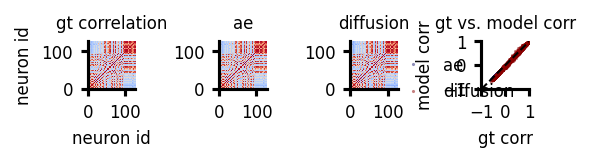

In [40]:
from ldns.utils.plotting_utils import plot_correlation_matrices

plot_correlation_matrices(
    gt_rates,
    [ae_rates, diffusion_rates],
    sample=None,
    mode="concatenate",
    model_labels=["ae", "diffusion"],
    model_colors=["midnightblue", "darkred"],
    figsize=cm2inch((10, 4)),
    ms=1,
)